In [1]:
import sys
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from functools import lru_cache
import random
import os
import sys

np.set_printoptions(threshold=sys.maxsize)

def num_attr(elem, path):
    return float(elem.attrib[path]) if '.' in elem.attrib[path] else int(elem.attrib[path])

def random_discrete(start, end, number_of_groups=7):
    step = np.round((end - start) / number_of_groups, 4)
    k = np.random.randint(0, number_of_groups)
    return np.round(start + k * step, 4)


class CellularMap:
    
    OBJECT_TO_VALUE = {
        'E': -1,
        'WT': -2,
        'WB': -3,
        'WR': -4,
        'WL': -5,
        'W': -6,
        'O': 0,
        'MU': -7
    }
    
    VALUE_TO_OBJECT = {v: k for k, v in OBJECT_TO_VALUE.items()}
    
    THIN_WALLS = ['WT','WB', 'WR', 'WL']
    
    xml_object_mapping = {
        './wall[@type="thick"]': OBJECT_TO_VALUE['W'],
        './wall[@type="thin_bottom"]': OBJECT_TO_VALUE['WB'],
        './wall[@type="thin_top"]': OBJECT_TO_VALUE['WT'],
        './wall[@type="thin_right"]': OBJECT_TO_VALUE['WR'],
        './wall[@type="thin_left"]': OBJECT_TO_VALUE['WL'],
        './mu_area': OBJECT_TO_VALUE['MU'],
        './exit': OBJECT_TO_VALUE['E']
    }
    
    directions = {'TL': (-1, -1), 'T': (-1, 0), 'TR': (-1, 1), 
                  'L': (0, -1),                 'R': (0, 1), 
                  'BL': (1, -1),  'B': (1, 0),  'BR': (1, 1)}
    
    def __init__(self, xml_str):
        #self.file_name = file_name
        self.xml_str = xml_str
        self.rooms = self.load_xml(xml_str, 'rooms')
        self.width = num_attr(self.rooms, 'width')
        self.height = num_attr(self.rooms, 'height')
        self.rooms_matrix = np.zeros((self.height, self.width))
        self.occupancy_matrix = np.zeros((self.height, self.width))
        self.mu = np.full((self.height, self.width), num_attr(self.rooms, 'default_mu'))
        self.exits_target = np.full((self.height, self.width), np.inf)
        self.rooms_id = np.full((self.height, self.width), -1)
        self.exit_flow_coordinates = self.get_coordinates_for_flow()
        self.get_neighbours = lru_cache(maxsize=None)(self._get_neighbours)
        
    def load_xml(self, xml_str, path):
        #tree = ET.parse(file_name)
        tree = ET.ElementTree(ET.fromstring(xml_str))
        root = tree.getroot()
        rooms = root.find(path)
        return rooms
    
    @staticmethod
    def rotational_sort(list_of_xy_coords):
        cx, cy = list_of_xy_coords.mean(0)
        x, y = list_of_xy_coords.T
        angles = np.arctan2(x-cx, y-cy)
        indices = np.argsort(angles)
        return list_of_xy_coords[indices]
    
    @staticmethod
    def get_vertices(obj):
        vertices = [[num_attr(v, 'px'), num_attr(v, 'py')] for v in obj.findall('./vertex')]
        return CellularMap.rotational_sort(np.array(vertices))
    
    def get_mask_by_radius(self, center_pos, radius):
        x = np.arange(0, self.height)
        y = np.arange(0, self.width)
        i, j = center_pos
        return (x[:,np.newaxis]-i)**2 + (y[np.newaxis,:]-j)**2 < (radius + 1) ** 2 
        
    def draw_object(self, path, obj, room_id):
        object_type = CellularMap.xml_object_mapping[path] 
        vertices = CellularMap.get_vertices(obj)
        length = len(vertices)
        
        if path == './mu_area':
            value = num_attr(obj, 'value')
            x_1, y_1 = vertices.min(axis=0)
            x_2, y_2 = vertices.max(axis=0)
            self.mu[x_1:x_2 + 1, y_1:y_2 + 1] = value
            return None
        elif path == './wall[@type="thick"]' and len(vertices) == 4:
            x_1, y_1 = vertices.min(axis=0)
            x_2, y_2 = vertices.max(axis=0)
            self.rooms_id[x_1:x_2 + 1, y_1:y_2 + 1] = room_id
            
        
        for i in range(length):
            first = i
            second = i + 1 if i + 1 < length else 0
            (x_1, y_1), (x_2, y_2) = sorted([vertices[first], vertices[second]], key=lambda k: [k[1], k[0]])
        
            if path == './exit':
                x = np.arange(0, self.height)
                y = np.arange(0, self.width)
                mu = num_attr(obj, 'mu')
                r = num_attr(obj, 'r')
                target_room = num_attr(obj, 'target_room')
                for i in range(x_1, x_2 + 1):
                    for j in range(y_1, y_2 + 1):
                        mask_radius = self.get_mask_by_radius((i, j), r)
                        mask_not_wall = np.where(self.rooms_matrix != CellularMap.OBJECT_TO_VALUE['W'], True, False)
                        mask = np.logical_and(mask_radius, mask_not_wall)
                        self.mu[mask] = mu
                self.exits_target[x_1:x_2 + 1, y_1:y_2 + 1] = target_room
            
            for i in range(x_1, x_2 + 1):
                for j in range(y_1, y_2 + 1):
                    current_value = self.rooms_matrix[i][j]
                    if current_value == CellularMap.OBJECT_TO_VALUE['O'] \
                    or object_type in [CellularMap.OBJECT_TO_VALUE['E'], 
                                       CellularMap.OBJECT_TO_VALUE['WT'], 
                                       CellularMap.OBJECT_TO_VALUE['WB'], 
                                       CellularMap.OBJECT_TO_VALUE['WL'], 
                                       CellularMap.OBJECT_TO_VALUE['WR']]:
                        self.rooms_matrix[i][j] = object_type 
                    #self.rooms_matrix[x_1:x_2 + 1, y_1:y_2 + 1] = object_type
        
    def load_object(self, room, path, room_id):
        for obj in room.findall(path):
            self.draw_object(path, obj, room_id)
            
    def load_map(self):
        for room in self.rooms.findall('./room'):
            room_id = num_attr(room, 'id')
            for path in CellularMap.xml_object_mapping.keys():
                self.load_object(room, path, room_id)
                
    def display_map(self):
        plt.imshow(self.rooms_matrix, cmap='hot', interpolation='nearest')
        plt.show()
        
    def get_coordinates_by_direction(self, x, y, direction):
        i, j = tuple(map(lambda i, j: i + j, (x, y), CellularMap.directions[direction]))
        if i >= 0 and i < self.height and j >= 0 and j < self.width:
            return i, j
        else:
            return None, None
        
    def get_cell_type(self, x, y, direction):
        i, j = self.get_coordinates_by_direction(x, y, direction)
        if i != None and j != None:
            return CellularMap.VALUE_TO_OBJECT[self.rooms_matrix[i][j]]
        else:
            return None
    
    def _get_neighbours(self, x, y):

        order = ['TL', 'T', 'TR', 'R', 'BR', 'B', 'BL', 'L']
        
        clockwise = {}
        for i in range(len(order)):
            clockwise[order[i]] = order[i+1 if i < len(order) - 1 else 0]
        
        counterclockwise = {v: k for k, v in clockwise.items()}
        
        banned = {
            'WT': 'T', 'WB': 'B', 'WR': 'R', 'WL': 'L'
        }
        
        opposite = {
            'T': 'B', 'B': 'T', 'L':'R', 'R': 'L',
            'WT': 'WB', 'WB': 'WT', 'WL': 'WR', 'WR': 'WL'
        }
        
        general_opposite = {
            'T': 'WB', 'R': 'WL', 'B': 'WT', 'L': 'WR'
        }
        
        
        current_type = CellularMap.VALUE_TO_OBJECT[self.rooms_matrix[x][y]]
        current_directions = CellularMap.directions.copy()
        
        neighbours = []
        cells_type = {}
                    
        if current_type in CellularMap.THIN_WALLS:
            cells_type = {}
            
            current_directions.pop(banned[current_type], None)
            
            for type_ in current_directions.keys():
                cells_type[type_] = self.get_cell_type(x, y, type_)
            
            opposite_type = opposite[current_type]
            order = order[order.index(banned[current_type]) - 1:] + order[:order.index(banned[current_type]) - 1]
            
            type_ = order[0]
            if cells_type[type_] and cells_type[type_] in ['W', opposite_type] or not cells_type[type_]:
                current_directions.pop(type_, None)
            
            type_ = order[2]
            if cells_type[type_] and cells_type[type_] in ['W', opposite_type] or not cells_type[type_]:
                current_directions.pop(type_, None)
            
            type_ = order[3]
            if cells_type[type_] and cells_type[type_] in ['W', current_type, 'W' + opposite[type_]]:
                current_directions.pop(counterclockwise[type_], None)
            if cells_type[type_] and cells_type[type_] in ['W', 'W' + opposite[type_]] or not cells_type[type_]:
                current_directions.pop(type_, None)
            
            type_ = order[4]
            if cells_type[type_] and cells_type[type_] in ['W'] or not cells_type[type_]:
                current_directions.pop(type_, None)
                
            if cells_type[type_] and cells_type[type_] in ['W', current_type] \
            and cells_type[clockwise[type_]] and cells_type[clockwise[type_]] in ['W', current_type]:
                current_directions.pop(type_, None)
                    
            type_ = order[5]
            if cells_type[type_] and cells_type[type_] in ['W', current_type] or not cells_type[type_]:
                current_directions.pop(type_, None)
                    
            type_ = order[6]
            if cells_type[type_] and cells_type[type_] in ['W'] or not cells_type[type_]:
                current_directions.pop(type_, None)
                
            if cells_type[type_] and cells_type[type_] in ['W', current_type] \
            and cells_type[counterclockwise[type_]] and cells_type[counterclockwise[type_]] in ['W', current_type]:
                current_directions.pop(type_, None)
                    
            type_ = order[7]
            if cells_type[type_] and cells_type[type_] in ['W', 'W' + opposite[type_], current_type]:
                current_directions.pop(cells_type[clockwise[type_]], None)
            if cells_type[type_] and cells_type[type_] in ['W', 'W' + opposite[type_]] or not cells_type[type_]:
                current_directions.pop(type_, None)
        else:
            cells_type = {}
            for type_ in current_directions.keys():
                cells_type[type_] = self.get_cell_type(x, y, type_)
            
       
            
            for i in range(0, len(order), 1):
                cell_1 = order[i]
                cell_2 = order[i+1 if i < len(order) - 1 else 0]
                s = cell_1 + cell_2
                general_direction = {s.count(i):i for i in set(s)}[2]
                opposite_type = general_opposite[general_direction]
                
                
                

                if cells_type[cell_1] in ['W', opposite_type] and cells_type[cell_2] in ['W', opposite_type]:
                    current_directions.pop(cell_1, None)
                    current_directions.pop(cell_2, None)
                elif cells_type[cell_1] == 'W' or not cells_type[cell_1]:
                    current_directions.pop(cell_1, None)
                    
            
        for direction in current_directions:
            i, j = self.get_coordinates_by_direction(x, y, direction)
            neighbours.append((i, j))
        

        return neighbours
    
    def init_static_field(self):    
        self.static_field = np.empty((self.height, self.width))  # static floor field
        self.static_field[:] = np.Inf
        all_exits = np.where(self.exits_target != np.inf)
        all_exits_coordinates = list(zip(all_exits[0], all_exits[1]))

        final_exits = np.min(self.exits_target)
        self.rooms_matrix[np.where((self.exits_target > final_exits) & 
                                   (self.exits_target < np.inf))] = CellularMap.OBJECT_TO_VALUE['O']
        
        exits_indices = np.where(self.exits_target == final_exits)
        exits_coordinates = list(zip(exits_indices[0], exits_indices[1]))
        
        cells_list = []
        for exit in exits_coordinates:
            self.static_field[exit] = 0
            cells_list.append(exit)

        while cells_list:
            cell = cells_list.pop(0)
            neighbours = self.get_neighbours(*cell)
            for neighbour in neighbours:
                if self.static_field[cell] + 1 < self.static_field[neighbour]:
                    self.static_field[neighbour] = self.static_field[cell] + 1
                    cells_list.append(neighbour)
        
        self.max_static_value = np.unique(self.static_field)[-2]
        self.min_static_value = np.min(self.static_field)
                    
                    
    def generate_random_agents(self, agents, pedestrian_params, aggressiveness_random, occupation_random):
        #x = np.arange(0, self.height)
        #y = np.arange(0, self.width)
        cx, cy = pedestrian_params['pos']
        
        ks = pedestrian_params['ks']
        kd = pedestrian_params['kd']
        ko = pedestrian_params['ko']
        gamma = pedestrian_params['gamma']
        color = pedestrian_params['color']
        r = pedestrian_params['r']

        #mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
        #mask = (y[np.newaxis,:]-cy)**2 + (x[:,np.newaxis]-cx)**2 < r**2
        mask = self.get_mask_by_radius((cx, cy), r)
        if agents.keys():
            mask[tuple(zip(*agents.keys()))] = False
        i_list, j_list = np.where(mask)
        indices = random.sample(range(len(i_list)), pedestrian_params['number'])
        
        for indx in indices:
            if len(aggressiveness_random) == 2:
                gamma = random_discrete(aggressiveness_random[0], aggressiveness_random[1])
            if occupation_random:
                ko = np.random.uniform(0, 1)
                #print(gamma)
            agents[i_list[indx], j_list[indx]] = Agent(i_list[indx], j_list[indx], ks, kd, ko, gamma, color)
            
        self.occupancy_matrix[i_list[indices],j_list[indices]] = 1
    
    def init_pedestrians(self, aggressiveness_random=[], occupation_random=False):
        agents = {}
        
        pedestrians = self.load_xml(self.xml_str, 'pedestrians')
        for group in pedestrians.findall('./group'):
            pedestrian_params = {}
            for param in group:
                if param.tag == 'vertex':
                    pedestrian_params['pos'] = (num_attr(param, 'px'), num_attr(param, 'py'))
                    pedestrian_params['r'] = num_attr(param, 'r')
                elif param.tag == 'color':
                    pedestrian_params['color'] = int(param.text)
                else:
                    pedestrian_params[param.tag] = float(param.text) if '.' in param.text else int(param.text)
            self.generate_random_agents(agents, pedestrian_params, aggressiveness_random, occupation_random)
        return agents
    
    def get_coordinates_for_flow(self):
        exit_flow_coordinates = ([], [])
        measurements_root = self.load_xml(self.xml_str, 'measurements')
        for param in measurements_root.find('./exit_flow'):
            exit_flow_coordinates[0].append(num_attr(param, 'px'))
            exit_flow_coordinates[1].append(num_attr(param, 'py'))
        return exit_flow_coordinates
            
    def plot_sff4(self, agents, i):
        """
        plots a numbered image. Useful for making movies
        """
        
        def plot_thin_walls(ax, cmap):
            for wall_type in CellularMap.THIN_WALLS:
                wall_indices = np.where(self.rooms_matrix == CellularMap.OBJECT_TO_VALUE[wall_type])
                wall_coordinates = list(zip(wall_indices[0], wall_indices[1]))
                for x, y in wall_coordinates:
                    if wall_type == 'WB':
                        ax.hlines(y=abs(x-self.height+1), 
                                  xmin=y, 
                                  xmax=y+1, 
                                  color="#333333", 
                                  linewidth=0.7)
                    elif wall_type == 'WT':
                        ax.hlines(y=abs(x-self.height+1), 
                                  xmin=y, 
                                  xmax=y+1, 
                                  color="#333333", 
                                  linewidth=0.7)
                    elif wall_type == 'WL':
                        ax.vlines(x=y, 
                                  ymin=abs(x-self.height), 
                                  ymax=abs(x-self.height+1), 
                                  color="#333333", 
                                  linewidth=0.7)
                    else:
                        ax.vlines(x=y+1, 
                                  ymin=abs(x-self.height), 
                                  ymax=abs(x-self.height+1), 
                                  color="#333333", 
                                  linewidth=0.7)
        fig = plt.figure(dpi=120)
        ax = fig.add_subplot(111)
        ax.cla()
        
        cmap = plt.get_cmap("jet").copy()
        cmap.set_bad(color='k', alpha=0.8)
        vect = self.static_field.copy()

        vect[self.rooms_matrix == CellularMap.OBJECT_TO_VALUE['W']] = np.Inf
        
        for x, y in zip(*self.exit_flow_coordinates):
            vect[x][y] = 300
        
        for x, y in zip(*np.where(self.occupancy_matrix == 1)):
            vect[x][y] = agents[x, y].gamma * 100
            
        max_value = np.unique(self.static_field)[-2]
        min_value = np.min(self.static_field)
        plt.imshow(vect, cmap=cmap, interpolation='nearest', vmin=min_value, 
                   vmax=max_value, extent=[0, self.width, 0, self.height])  # lanczos nearest
        plt.colorbar()
        plot_thin_walls(ax, cmap)
        
        
    def plot_sff5(self, agents, i):
        dpi = 120
        
        def plot_thin_walls(ax, cmap):
            for wall_type in CellularMap.THIN_WALLS:
                wall_indices = np.where(self.rooms_matrix == CellularMap.OBJECT_TO_VALUE[wall_type])
                wall_coordinates = list(zip(wall_indices[0], wall_indices[1]))
                for x, y in wall_coordinates:
                    if wall_type == 'WB':
                        ax.hlines(y=abs(x-self.height+1), 
                                  xmin=y, 
                                  xmax=y+1, 
                                  color="#333333", 
                                  linewidth=0.7)
                    elif wall_type == 'WT':
                        ax.hlines(y=abs(x-self.height+1), 
                                  xmin=y, 
                                  xmax=y+1, 
                                  color="#333333", 
                                  linewidth=0.7)
                    elif wall_type == 'WL':
                        ax.vlines(x=y, 
                                  ymin=abs(x-self.height), 
                                  ymax=abs(x-self.height+1), 
                                  color="#333333", 
                                  linewidth=0.7)
                    else:
                        ax.vlines(x=y+1, 
                                  ymin=abs(x-self.height), 
                                  ymax=abs(x-self.height+1), 
                                  color="#333333", 
                                  linewidth=0.7)

        fig = plt.figure(figsize=(7, 7), dpi=dpi)
        ax = fig.add_subplot(111)
        ax.cla()
        cmap = plt.get_cmap('YlGnBu').copy()
        cmap.set_bad(color='k', alpha=0.8)
        vect = self.rooms_matrix.copy()

        vect[self.rooms_matrix == CellularMap.OBJECT_TO_VALUE['W']] = np.Inf
        
        for pos, agent in agents.items():
            vect[pos[0]][pos[1]] = agent.color
        
        plt.imshow(vect, cmap=cmap, interpolation='nearest', 
                   vmin=self.min_static_value, 
                   vmax=self.max_static_value, 
                   extent=[0, self.width, 0, self.height])

        plot_thin_walls(ax, cmap)
        
        plt.title("%.6d"%i)
        figure_name = os.path.join('sff', '%.6d.png'%i)
        plt.savefig(figure_name)
        #plt.close()
    
    def is_occupied(self, pos_1, pos_2):
        if pos_1 == pos_2 or self.occupancy_matrix[pos_2] == 0:
            return 0
        else:
            return 1
        
class Agent:
    
    def __init__(self, x, y, ks, kd, ko, gamma, color):
        self.x = x
        self.y = y
        self.pos = (x, y)
        self.ks = ks
        self.kd = kd
        self.ko = ko
        self.gamma = gamma
        self.color = color

In [2]:
from collections import Counter

def is_diagonal_movement(pos_1, pos_2):
    x_1, x_2 = pos_1
    y_1, y_2 = pos_2
    return 1 if (x_1 - y_1) * (x_2 - y_2) != 0 else 0

def get_conflict_mapping(mapping):
    conflicts_counter = Counter(mapping.values())
    conflicts_counter = {x: count for x, count in conflicts_counter.items() if count > 1}
    conflicts = {}
    for key, value in conflicts_counter.items():
        res = []
        for curr_pos, target_pos in mapping.items():
            if target_pos == key:
                res.append(curr_pos)
        conflicts[key] = res
    return conflicts


def get_probabilities(cellular_map, agent, neighbours):
    current_pos = agent.pos
    N = len(neighbours)
    p_s = np.zeros((N,), dtype=np.float64)
    p_o = np.zeros((N,), dtype=np.float64)
    P_s = np.zeros((N,), dtype=np.float64)
    P_o = np.zeros((N,), dtype=np.float64)
    
    for i, neighbour in enumerate(neighbours):
        Sy = cellular_map.static_field[neighbour]
        Oxy = cellular_map.is_occupied(current_pos, neighbour)
        Dxy = is_diagonal_movement(current_pos, neighbour)

        p_s[i] = np.exp(-agent.ks * Sy) * (1 - agent.kd * Dxy)
        p_o[i] = np.exp(-agent.ks * Sy) * (1 - Oxy) * (1 - agent.kd * Dxy)
            
    Ps_sum = np.sum(p_s)
    Po_sum = np.sum(p_o)
    for i in range(N):
        P_s[i] = p_s[i] / Ps_sum
        P_o[i] = p_o[i] / Po_sum
    return agent.ko * P_o + (1 - agent.ko) * P_s

def resolve_conflict(conflicts, mapping, agents):
    for conflict_target_pos, agents_pos in conflicts.items():
        mu = cellular_map.mu[conflict_target_pos]
        gamma_list = [agents[agent_pos].gamma for agent_pos in agents_pos]
        max_gamma = max(gamma_list)
        aggressive_agent_indices = [index for index, curr_gamma in enumerate(gamma_list) if curr_gamma == max_gamma]
        if len(aggressive_agent_indices) > 1:
            block_prob = mu * (1 - max_gamma)
            if random.random() > block_prob:
                choosed_agent_index = random.choice(aggressive_agent_indices)
                choosed_agent_pos = agents_pos[choosed_agent_index]
                choosed_agent = agents[choosed_agent_pos]
                mapping[choosed_agent.pos] = conflict_target_pos
                agents_pos.pop(choosed_agent_index)
        else:
            choosed_agent_index = aggressive_agent_indices[0]
            choosed_agent_pos = agents_pos[choosed_agent_index]
            choosed_agent = agents[choosed_agent_pos]
            mapping[choosed_agent.pos] = conflict_target_pos
            agents_pos.pop(choosed_agent_index)
            
        for agent_pos in agents_pos:
            mapping[agent_pos] = agent_pos
            
def clean_bond_conflicts(bonds_mapping, next_step_mapping):
    keys_to_resolve = list(bonds_mapping.keys())
    if not keys_to_resolve:
        return None
    
    for curr_pos in keys_to_resolve:
        target_pos = bonds_mapping[curr_pos]
        if curr_pos == target_pos:
            next_step_mapping[curr_pos] = curr_pos
            bonds_mapping.pop(curr_pos, None)

            
def find_chain(bonds_mapping, key, value):
    chain = [key]
    while value in bonds_mapping.keys():
        if bonds_mapping[value] != None:
            if value not in chain:
                key = value
                value = bonds_mapping[value]
                chain.append(key)
            else:
                return chain, True if len(chain) == 2 else False
        else:
            return chain, False
    return chain, False
    
def resolve_bonds(bonds_mapping, next_step_mapping):
    keys_to_resolve = list(bonds_mapping.keys())
    
    if not keys_to_resolve:
        return None
            

    to_resolve = []

    for key in keys_to_resolve:
        if key in bonds_mapping.keys():
            new_chain, chain_to_block = find_chain(bonds_mapping, key, bonds_mapping[key])
            if chain_to_block:
                for curr_pos in new_chain[::-1]:
                    next_step_mapping[curr_pos] = curr_pos
                    del bonds_mapping[curr_pos]
            else:
                to_resolve += new_chain[::-1]

    to_resolve = list(dict.fromkeys(to_resolve))
    for curr_pos in to_resolve:
        target_pos = bonds_mapping[curr_pos]
        next_step = next_step_mapping.get(target_pos, None) or bonds_mapping.get(target_pos, None)
        if target_pos != next_step:
            next_step_mapping[curr_pos] = target_pos
            del bonds_mapping[curr_pos]
        else:
            next_step_mapping[curr_pos] = curr_pos
            
def get_agents_count(cellular_map, current_room_id):
    return np.sum(cellular_map.occupancy_matrix[cellular_map.rooms_id == current_room_id])

def simulate(agents, cellular_map, render=False):
    agents_count = np.sum(cellular_map.occupancy_matrix)
    agents_total = agents_count
    agents_in_room = agents_count
    T = 0
    i = 0
    exit_flow_history = []
    density_flow_history = []
    total_agents_history = []
    max_ks = 744 / cellular_map.max_static_value
    bonds_mapping = {}
    while agents_count > 0:
        next_step_mapping = {}
        free_agents = []
        for current_pos, agent in agents.items():
            if agent.ks < max_ks and cellular_map.rooms_id[current_pos] == -1:
                agents[current_pos].ks = max_ks
            if cellular_map.static_field[current_pos] == 0:
                free_agents.append(current_pos)
                next_step_mapping[current_pos] = (current_pos[0] + 9999, current_pos[1] + 9999)
                continue
            
            neighbours = cellular_map.get_neighbours(agent.x, agent.y).copy()
            neighbours.append(current_pos)
        
            probabilities = get_probabilities(cellular_map, agent, neighbours)
            target_pos = random.choices(neighbours, weights=probabilities)[0]
        
            if cellular_map.is_occupied(current_pos, target_pos):
                bonds_mapping[current_pos] = target_pos
            else:
                next_step_mapping[current_pos] = target_pos
        
        
        conflicts = get_conflict_mapping(next_step_mapping)
        resolve_conflict(conflicts, next_step_mapping, agents)
        
        
        bond_conflicts = get_conflict_mapping(bonds_mapping)
        resolve_conflict(bond_conflicts, bonds_mapping, agents)
        
        clean_bond_conflicts(bonds_mapping, next_step_mapping)
        resolve_bonds(bonds_mapping, next_step_mapping)
        
        
        agents_new = {}
        
        for cur_pos, target_pos in next_step_mapping.items():
            cellular_map.occupancy_matrix[cur_pos] = 0
        
        for cur_pos, target_pos in next_step_mapping.items():
            if cur_pos in free_agents:
                agents_count -= 1
            else:
                agents_new[target_pos] = agents[cur_pos]
                agents_new[target_pos].pos = target_pos
                agents_new[target_pos].x = target_pos[0]
                agents_new[target_pos].y = target_pos[1]
                cellular_map.occupancy_matrix[target_pos] = 1
        agents = agents_new.copy()
        if render:
            cellular_map.plot_sff5(agents, i)
        i += 1
        
        new_agents_in_room = get_agents_count(cellular_map, 1)
        
        if T == 0:
            density_flow_history.append(int(np.sum(cellular_map.occupancy_matrix[cellular_map.exit_flow_coordinates])))
            total_agents_history.append(new_agents_in_room)
            
            if (agents_in_room != new_agents_in_room):
                exit_flow_history.append(agents_in_room - new_agents_in_room)
            else:
                exit_flow_history.append(0)
            
        agents_in_room = new_agents_in_room
        
        if agents_in_room == 0 and T == 0:
            T = i
    return agents_total, T, exit_flow_history, total_agents_history, density_flow_history

70.0


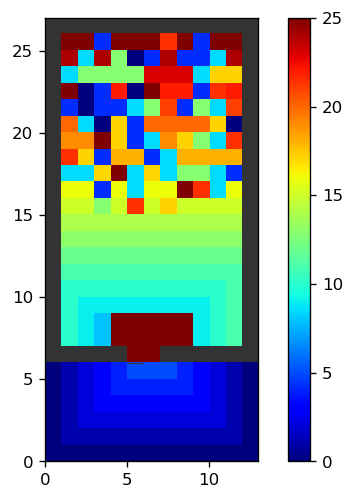

In [3]:
from string import Template

d = {
'default_ks': 0.3,
'default_ko': 0.9,
'default_kd': 0.7,
'default_mu': 0.3,
'default_mu_exit': 0.8,
'default_mu_radius_exit': 1,
'default_ped_number': 70,
'default_gamma': 0.5
}


with open('templates/geometry_template_m_room1.xml', 'r') as f:
    d['default_ks'] = np.round(3.5, 2)
    src = Template(f.read())
    xml_str = src.substitute(d)
    cellular_map = CellularMap(xml_str)
    cellular_map.load_map()
    cellular_map.init_static_field()
    agents = cellular_map.init_pedestrians(aggressiveness_random=[0, 0.3], occupation_random=False)
    #agents_total, T, exit_flow_history, total_agents_history, density_flow_history = simulate(agents, cellular_map, render=False)
    
print(np.sum(cellular_map.occupancy_matrix))
cellular_map.plot_sff4(agents, 1)

In [4]:
from string import Template

d = {
'default_ks': 3.5,
'default_ko': 0.9,
'default_kd': 0.7,
'default_mu': 0.3,
'default_mu_exit': 0.8,
'default_mu_radius_exit': 1,
'default_ped_number': 70,
'default_gamma': 0.5
}

n_runs = 1000
room_type = 4

for room_type in [1]:
    f = open('results3/histor_room_{}_random_gamma_discrete_2.csv'.format(room_type), 'w')
    f.write('room_type,ped_number,gamma,agents,T,flow_history,total_agents_history,density_flow_history\n')
    f.close()
    for gamma1 in [0.3]:
        for gamma2 in np.arange(gamma1 + 0.1, 1., 0.1):
            try:
                #d['default_gamma'] = gamma
                fd = open('results3/histor_room_{}_random_gamma_discrete_2.csv'.format(room_type), 'a')
                with open('templates/geometry_template_m_room{}.xml'.format(room_type), 'r') as f:
                    #print(room_type)
                    print(room_type, '({}-{})'.format(np.round(gamma1, 2), np.round(gamma2, 2)))
                    src = Template(f.read())
                    xml_str = src.substitute(d)
                    for t in range(n_runs):
                        cellular_map = CellularMap(xml_str)
                        cellular_map.load_map()
                        cellular_map.init_static_field()
                        agents = cellular_map.init_pedestrians(aggressiveness_random=[gamma1, gamma2], occupation_random=False)
                        agents_total, T, exit_flow_history, total_agents_history, density_flow_history = simulate(agents, cellular_map, render=False)
                
                        fd.write("""{},{},{},{},{},"{}","{}","{}"\n""".format(room_type, 
                                                            d['default_ped_number'],
                                                            '({}-{})'.format(np.round(gamma1, 2), np.round(gamma2,2)),
                                                            agents_total, 
                                                            T, 
                                                            exit_flow_history, total_agents_history, density_flow_history))
                    
                        if t % 100 == 0:
                            print(t, room_type, '({}-{})'.format(np.round(gamma1, 2), np.round(gamma2,2)))
                fd.close()
            except Exception as e:
                print(e)

1 (0.3-0.4)
0 1 (0.3-0.4)
100 1 (0.3-0.4)
200 1 (0.3-0.4)
300 1 (0.3-0.4)
400 1 (0.3-0.4)
500 1 (0.3-0.4)
600 1 (0.3-0.4)
700 1 (0.3-0.4)
800 1 (0.3-0.4)
900 1 (0.3-0.4)
1 (0.3-0.5)
0 1 (0.3-0.5)
100 1 (0.3-0.5)
200 1 (0.3-0.5)
300 1 (0.3-0.5)
400 1 (0.3-0.5)
500 1 (0.3-0.5)
600 1 (0.3-0.5)
700 1 (0.3-0.5)
800 1 (0.3-0.5)
900 1 (0.3-0.5)
1 (0.3-0.6)
0 1 (0.3-0.6)
100 1 (0.3-0.6)
200 1 (0.3-0.6)
300 1 (0.3-0.6)
400 1 (0.3-0.6)
500 1 (0.3-0.6)
600 1 (0.3-0.6)
700 1 (0.3-0.6)
800 1 (0.3-0.6)
900 1 (0.3-0.6)
1 (0.3-0.7)
0 1 (0.3-0.7)
100 1 (0.3-0.7)
200 1 (0.3-0.7)
300 1 (0.3-0.7)
400 1 (0.3-0.7)
500 1 (0.3-0.7)
600 1 (0.3-0.7)
700 1 (0.3-0.7)
800 1 (0.3-0.7)
900 1 (0.3-0.7)
1 (0.3-0.8)
0 1 (0.3-0.8)
100 1 (0.3-0.8)
200 1 (0.3-0.8)
300 1 (0.3-0.8)
400 1 (0.3-0.8)
500 1 (0.3-0.8)
600 1 (0.3-0.8)
700 1 (0.3-0.8)
800 1 (0.3-0.8)
900 1 (0.3-0.8)
1 (0.3-0.9)
0 1 (0.3-0.9)
100 1 (0.3-0.9)
200 1 (0.3-0.9)
300 1 (0.3-0.9)
400 1 (0.3-0.9)
500 1 (0.3-0.9)
600 1 (0.3-0.9)
700 1 (0.3-0.9)
800 1 (0.3-0